# Classificador de Texto para Decisões do STF (Versão Final para Publicação)

## Objetivo
Este notebook apresenta um pipeline completo e robusto para a classificação de textos jurídicos. As principais características são:

1.  **Metodologia Comparativa:** Avaliação de 7 algoritmos de classificação distintos.
2.  **Otimização por Precisão:** O `GridSearchCV` otimiza os hiperparâmetros de cada modelo para **Precisão**, visando minimizar falsos positivos.
3.  **Seleção Estatística em Cascata:** O melhor modelo geral é escolhido através de uma hierarquia de critérios com validação estatística (Friedman + Nemenyi), com exibição das matrizes de p-valores.
4.  **Metodologia Robusta:** Utiliza `Pipelines` para evitar *data leakage* e `RepeatedStratifiedKFold` para resultados de validação estáveis.

In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.stem.rslp import RSLPStemmer
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, make_scorer, f1_score

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

try:
    nltk.data.find('stemmers/rslp')
except LookupError:
    print("Pacote 'rslp' do NLTK não encontrado. Baixando...")
    nltk.download('rslp')

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
np.random.seed(42)

## Funções Auxiliares

In [ ]:
def load_and_prepare_data(file_path):
    """Carrega e prepara os dados iniciais."""
    print(f"Carregando dados de '{file_path}'...")
    df = pd.read_excel(file_path)
    df_complete = pd.DataFrame({
        'label': df.iloc[:, 0], 'nome_pdf': df.iloc[:, 1],
        'termos_encontrados': df.iloc[:, 2], 'text': df.iloc[:, -1]
    })
    df_complete.dropna(subset=['text'], inplace=True)
    valid_labels = ['Sim', 'Não']
    df_labeled = df_complete[df_complete['label'].isin(valid_labels)].copy().reset_index(drop=True)
    print(f"Dados carregados: {len(df_complete)} amostras totais, {len(df_labeled)} rotuladas.")
    return df_complete, df_labeled

def preprocess_text(text, stemmer):
    """Aplica limpeza, normalização e stemming ao texto."""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Zà-úÀ-Ú\s]', '', text)
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def plot_grid_search_results(grid_search, model_name):
    """Exibe os resultados do GridSearchCV em uma tabela formatada."""
    print(f"\n--- Parâmetros Otimizados para {model_name} ---")
    print(f"Melhor combinação de parâmetros: {grid_search.best_params_}")
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    cols_to_show = ['mean_test_score', 'std_test_score', 'rank_test_score']
    param_cols = [col for col in cv_results_df.columns if col.startswith('param_')]
    print("\nVisão geral dos resultados do Grid Search (otimizando por Precisão):")
    with pd.option_context('display.max_rows', 5):
        display(cv_results_df[param_cols + cols_to_show].sort_values(by='rank_test_score'))

def train_and_optimize_models(df_labeled):
    """Executa o pipeline de treinamento, otimização e coleta de resultados."""
    print("\nIniciando processo de treinamento e otimização...")
    stemmer = RSLPStemmer()
    df_labeled['text_processed'] = df_labeled['text'].apply(lambda x: preprocess_text(x, stemmer))
    
    label_encoder = LabelEncoder()
    X = df_labeled['text_processed']
    y = label_encoder.fit_transform(df_labeled['label'])
    X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    tfidf = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, max_df=0.95)
    
    pipelines = {
        'LogisticRegression': Pipeline([('vectorizer', tfidf), ('scaler', StandardScaler(with_mean=False)), ('clf', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))]),
        'RandomForest': Pipeline([('vectorizer', tfidf), ('clf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))]),
        'LightGBM': Pipeline([('vectorizer', tfidf), ('clf', LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))]),
        'XGBoost': Pipeline([('vectorizer', tfidf), ('clf', XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', use_label_encoder=False))]),
        'SVC': Pipeline([('vectorizer', tfidf), ('scaler', StandardScaler(with_mean=False)), ('clf', SVC(random_state=42, class_weight='balanced', probability=True))]),
        'KNeighbors': Pipeline([('vectorizer', tfidf), ('scaler', StandardScaler(with_mean=False)), ('clf', KNeighborsClassifier(n_jobs=-1))]),
        'MLPClassifier': Pipeline([('vectorizer', tfidf), ('scaler', StandardScaler(with_mean=False)), ('clf', MLPClassifier(random_state=42, max_iter=1000, early_stopping=True))])
    }
    param_grids = {
        'LogisticRegression': {'vectorizer__max_features': [1500, 2000, 3000], 'clf__C': [1, 10, 20], 'clf__solver': ['liblinear']},
        'RandomForest': {'vectorizer__max_features': [1500, 2000, 3000], 'clf__n_estimators': [200, 300], 'clf__max_depth': [20, None]},
        'LightGBM': {'vectorizer__max_features': [1500, 2000, 3000], 'clf__n_estimators': [100, 200], 'clf__learning_rate': [0.05, 0.1]},
        'XGBoost': {'vectorizer__max_features': [1500, 2000, 3000], 'clf__n_estimators': [100, 200], 'clf__max_depth': [3, 6]},
        'SVC': {'vectorizer__max_features': [1500, 2000, 3000], 'clf__C': [1, 10], 'clf__kernel': ['linear', 'rbf']},
        'KNeighbors': {'vectorizer__max_features': [1500, 2000, 3000], 'clf__n_neighbors': [3, 5, 7]},
        'MLPClassifier': {'vectorizer__max_features': [1500, 2000, 3000], 'clf__hidden_layer_sizes': [(50,), (100,)], 'clf__alpha': [0.0001, 0.001]}
    }
    
    cv_strategy = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
    optimized_models = {}
    test_results_summary = {}
    cv_results_collection = {}
    
    pos_label = list(label_encoder.classes_).index('Sim')
    scorers = {
        'accuracy': make_scorer(accuracy_score),
        'precision_sim': make_scorer(precision_score, pos_label=pos_label, zero_division=0),
        'f1_macro': make_scorer(f1_score, average='macro')
    }

    for name in pipelines.keys():
        print(f"\n  Otimizando {name}...")
        grid_search = GridSearchCV(pipelines[name], param_grids[name], cv=cv_strategy, scoring=scorers['precision_sim'], n_jobs=-1, refit=True)
        grid_search.fit(X_train_text, y_train)
        optimized_models[name] = grid_search.best_estimator_
        plot_grid_search_results(grid_search, name)
        
        y_pred = grid_search.predict(X_test_text)
        test_results_summary[name] = {
            'precision_sim': precision_score(y_test, y_pred, pos_label=pos_label, zero_division=0),
            'accuracy': accuracy_score(y_test, y_pred),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'y_pred': y_pred
        }
        
        cv_results_collection[name] = {}
        for scorer_name, scorer_func in scorers.items():
            cv_scores = cross_val_score(grid_search.best_estimator_, X_train_text, y_train, cv=cv_strategy, scoring=scorer_func, n_jobs=-1)
            cv_results_collection[name][scorer_name] = cv_scores
            
    return optimized_models, test_results_summary, cv_results_collection, X_train_text, y_train, X_test_text, y_test, label_encoder

def display_summary_table(test_results, cv_results):
    print("\n--- Tabela Resumo de Desempenho dos Modelos ---")
    df_test = pd.DataFrame(test_results).T[['accuracy', 'precision_sim', 'f1_macro']]
    df_test.columns = ['Acurácia (Teste)', 'Precisão "Sim" (Teste)', 'F1-Score Macro (Teste)']
    
    cv_acc_mean = {name: np.mean(scores['accuracy']) for name, scores in cv_results.items()}
    cv_prec_mean = {name: np.mean(scores['precision_sim']) for name, scores in cv_results.items()}
    df_cv = pd.DataFrame({'Acurácia (CV)': cv_acc_mean, 'Precisão "Sim" (CV)': cv_prec_mean})
    
    df_summary = df_cv.join(df_test).sort_values(by='Precisão "Sim" (Teste)', ascending=False)
    display(df_summary.style.format("{:.4f}"))
    
def plot_model_comparison(test_results_summary):
    print("\n--- Gráfico Comparativo de Desempenho no Conjunto de Teste ---")
    df_results = pd.DataFrame(test_results_summary).T
    df_to_plot = df_results[['accuracy', 'precision_sim']].sort_values(by='precision_sim', ascending=False)
    
    ax = df_to_plot.plot(kind='bar', figsize=(12, 7), rot=45)
    plt.title('Comparação de Acurácia e Precisão (Sim) no Teste', fontsize=14)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Modelos', fontsize=12)
    plt.ylim(0, 1.1)
    plt.legend(['Acurácia', 'Precisão (Sim)'])
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=9, xytext=(0, 5), textcoords='offset points')
    plt.tight_layout()
    plt.show()
    
def select_best_model_statistically(cv_results_collection, test_results_summary):
    print("\n--- Seleção Estatística do Melhor Modelo ---")
    
    metrics_hierarchy = [('precision_sim', 'Precisão (Sim)'), ('accuracy', 'Acurácia'), ('f1_macro', 'F1-Score (Macro)')]
    candidate_models = list(cv_results_collection.keys())

    for i, (metric_key, metric_name) in enumerate(metrics_hierarchy):
        print(f"\nEtapa {i+1}: Avaliando modelos pela métrica '{metric_name}'")
        print(f"Candidatos: {candidate_models}")
        
        if len(candidate_models) == 1:
            print(f"Apenas um candidato restante. {candidate_models[0]} é o vencedor.")
            break
            
        scores_to_test = [cv_results_collection[name][metric_key] for name in candidate_models]
        
        f_statistic, p_value = friedmanchisquare(*scores_to_test)
        print(f"  Teste de Friedman para '{metric_name}': p-valor={p_value:.4f}")
        
        if p_value < 0.05:
            p_values_nemenyi = sp.posthoc_nemenyi_friedman(np.array(scores_to_test).T)
            p_values_nemenyi.columns = candidate_models
            p_values_nemenyi.index = candidate_models
            
            print("  Matriz de p-valores (Teste de Nemenyi):")
            display(p_values_nemenyi.style.applymap(lambda x: 'background-color: yellow' if x < 0.05 else '').format("{:.4f}"))
            
            mean_scores = pd.Series({name: np.mean(scores) for name, scores in zip(candidate_models, scores_to_test)})
            best_model_name_in_group = mean_scores.idxmax()
            
            non_significant_rivals = p_values_nemenyi.index[p_values_nemenyi[best_model_name_in_group] >= 0.05].tolist()
            top_contenders = list(set([best_model_name_in_group] + non_significant_rivals))
            candidate_models = [m for m in candidate_models if m in top_contenders]
            print(f"  Grupo com melhor desempenho estatístico: {candidate_models}")
        else:
            print("  Não há diferença estatística significativa. Todos os candidatos avançam.")

    if len(candidate_models) > 1:
        print(f"\nDesempate final: {len(candidate_models)} modelos são estatisticamente equivalentes. Selecionando o de maior acurácia no teste.")
        final_accuracies = {name: test_results_summary[name]['accuracy'] for name in candidate_models}
        best_model_name = max(final_accuracies, key=final_accuracies.get)
    else:
        best_model_name = candidate_models[0]
        
    print(f"\nO VENCEDOR FINAL É: {best_model_name}")
    return best_model_name

def evaluate_final_model(model_name, optimized_models, test_results_summary, y_test, label_encoder):
    print(f"\n--- Avaliação Detalhada do Modelo Vencedor: {model_name} ---")
    model_pipeline = optimized_models[model_name]
    y_pred = test_results_summary[model_name]['y_pred']
    
    print("Relatório de Classificação (no conjunto de teste):")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matriz de Confusão - {model_name}', fontsize=14)
    plt.xlabel('Predito', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    plt.show()
    
    vectorizer = model_pipeline.named_steps['vectorizer']
    final_estimator = model_pipeline.named_steps['clf']
    importances = None
    if hasattr(final_estimator, 'feature_importances_'):
        importances = final_estimator.feature_importances_
    elif hasattr(final_estimator, 'coef_'):
        is_linear_svc = isinstance(final_estimator, SVC) and final_estimator.kernel == 'linear'
        is_logistic = isinstance(final_estimator, LogisticRegression)
        if is_linear_svc or is_logistic:
            importances = np.abs(final_estimator.coef_[0])
        
    if importances is not None:
        feature_names = vectorizer.get_feature_names_out()
        df_imp = pd.DataFrame(data={'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(20)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=df_imp, palette='viridis')
        plt.title(f'Top 20 Features Mais Importantes - {model_name}', fontsize=14)
        plt.show()
    else:
        print(f"\nAnálise de Feature Importance não é diretamente suportada para o modelo {model_name} com os parâmetros escolhidos.")

def generate_final_excel(model_name, optimized_models, df_complete, label_encoder):
    print("\n--- Gerando relatório final com predições para a base completa ---")
    model_pipeline = optimized_models[model_name]
    stemmer = RSLPStemmer()
    
    df_complete['text_processed'] = df_complete['text'].apply(lambda x: preprocess_text(x, stemmer))
    
    y_pred_full = model_pipeline.predict(df_complete['text_processed'])
    y_pred_labels = label_encoder.inverse_transform(y_pred_full)
    
    df_final = df_complete.copy()
    df_final['predicted_label'] = y_pred_labels
    df_final['prediction_confidence'] = model_pipeline.predict_proba(df_complete['text_processed']).max(axis=1)
    
    df_final.drop(columns=['text_processed'], inplace=True)

    output_file = 'base_completa_predicoes_final.xlsx'
    df_final.to_excel(output_file, index=False)
    print(f"\nArquivo Excel com todas as predições foi salvo como: '{output_file}'")

## Execução do Fluxo de Classificação

Carregando dados de 'termos_encontrados_rotulados.xlsx'...
Dados carregados: 4849 amostras totais, 458 rotuladas.


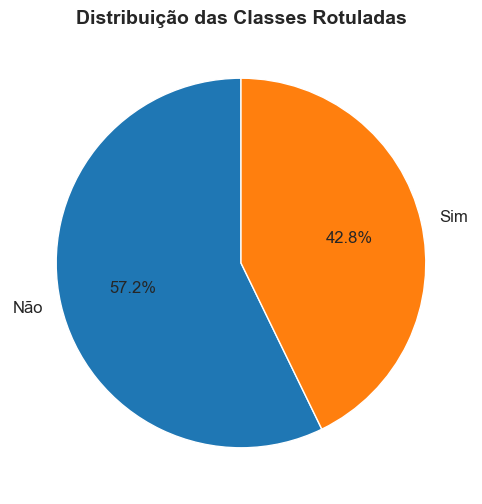


Iniciando processo de treinamento e otimização...

  Otimizando LogisticRegression...

--- Parâmetros Otimizados para LogisticRegression ---
Melhor combinação de parâmetros: {'clf__C': 20, 'clf__solver': 'liblinear', 'vectorizer__max_features': 3000}

Visão geral dos resultados do Grid Search (otimizando por Precisão):


,param_clf__C,param_clf__solver,param_vectorizer__max_features,mean_test_score,std_test_score,rank_test_score
8,20,liblinear,3000,0.908988,0.074590,1
5,10,liblinear,3000,0.907654,0.073540,2
...,...,...,...,...,...,...
3,10,liblinear,1500,0.890242,0.075996,8
6,20,liblinear,1500,0.889213,0.076542,9



  Otimizando RandomForest...

--- Parâmetros Otimizados para RandomForest ---
Melhor combinação de parâmetros: {'clf__max_depth': 20, 'clf__n_estimators': 300, 'vectorizer__max_features': 3000}

Visão geral dos resultados do Grid Search (otimizando por Precisão):


,param_clf__max_depth,param_clf__n_estimators,param_vectorizer__max_features,mean_test_score,std_test_score,rank_test_score
5,20,300,3000,0.907514,0.080587,1
6,None,200,1500,0.907050,0.071032,2
...,...,...,...,...,...,...
4,20,300,2000,0.899081,0.075113,11
1,20,200,2000,0.897624,0.073988,12



  Otimizando LightGBM...
[LightGBM] [Info] Number of positive: 147, number of negative: 196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3168
[LightGBM] [Info] Number of data points in the train set: 343, number of used features: 229
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

,param_clf__learning_rate,param_clf__n_estimators,param_vectorizer__max_features,mean_test_score,std_test_score,rank_test_score
3,0.05,200,1500,0.873027,0.084944,1
9,0.1,200,1500,0.868722,0.078632,2
...,...,...,...,...,...,...
1,0.05,100,2000,0.847158,0.080106,11
2,0.05,100,3000,0.846946,0.082234,12



  Otimizando XGBoost...

--- Parâmetros Otimizados para XGBoost ---
Melhor combinação de parâmetros: {'clf__max_depth': 3, 'clf__n_estimators': 200, 'vectorizer__max_features': 2000}

Visão geral dos resultados do Grid Search (otimizando por Precisão):


,param_clf__max_depth,param_clf__n_estimators,param_vectorizer__max_features,mean_test_score,std_test_score,rank_test_score
4,3,200,2000,0.872470,0.084917,1
1,3,100,2000,0.867835,0.079391,2
...,...,...,...,...,...,...
2,3,100,3000,0.853419,0.074996,11
5,3,200,3000,0.849131,0.077300,12



  Otimizando SVC...

--- Parâmetros Otimizados para SVC ---
Melhor combinação de parâmetros: {'clf__C': 10, 'clf__kernel': 'rbf', 'vectorizer__max_features': 1500}

Visão geral dos resultados do Grid Search (otimizando por Precisão):


,param_clf__C,param_clf__kernel,param_vectorizer__max_features,mean_test_score,std_test_score,rank_test_score
9,10,rbf,1500,0.930593,0.066142,1
11,10,rbf,3000,0.928461,0.077115,2
...,...,...,...,...,...,...
0,1,linear,1500,0.890023,0.076181,11
6,10,linear,1500,0.890023,0.076181,11



  Otimizando KNeighbors...

--- Parâmetros Otimizados para KNeighbors ---
Melhor combinação de parâmetros: {'clf__n_neighbors': 3, 'vectorizer__max_features': 3000}

Visão geral dos resultados do Grid Search (otimizando por Precisão):


,param_clf__n_neighbors,param_vectorizer__max_features,mean_test_score,std_test_score,rank_test_score
2,3,3000,0.906236,0.109818,1
1,3,2000,0.898172,0.102524,2
...,...,...,...,...,...
3,5,1500,0.805965,0.093947,8
6,7,1500,0.786553,0.114625,9



  Otimizando MLPClassifier...

--- Parâmetros Otimizados para MLPClassifier ---
Melhor combinação de parâmetros: {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (100,), 'vectorizer__max_features': 2000}

Visão geral dos resultados do Grid Search (otimizando por Precisão):


,param_clf__alpha,param_clf__hidden_layer_sizes,param_vectorizer__max_features,mean_test_score,std_test_score,rank_test_score
4,0.0001,"(100,)",2000,0.890165,0.086594,1
10,0.001,"(100,)",2000,0.888281,0.084748,2
...,...,...,...,...,...,...
3,0.0001,"(100,)",1500,0.853248,0.088759,11
9,0.001,"(100,)",1500,0.852634,0.088654,12



--- Tabela Resumo de Desempenho dos Modelos ---


,Acurácia (CV),"Precisão ""Sim"" (CV)",Acurácia (Teste),"Precisão ""Sim"" (Teste)",F1-Score Macro (Teste)
KNeighbors,0.7937,0.9062,0.8609,0.9714,0.8500
SVC,0.9054,0.9306,0.9217,0.9545,0.9188
MLPClassifier,0.8665,0.8902,0.9130,0.9535,0.9094
LogisticRegression,0.9113,0.9090,0.9043,0.9318,0.9007
RandomForest,0.9009,0.9075,0.8783,0.8571,0.8755
LightGBM,0.8818,0.8730,0.8435,0.8163,0.8400
XGBoost,0.8741,0.8725,0.8000,0.7500,0.7970



--- Gráfico Comparativo de Desempenho no Conjunto de Teste ---


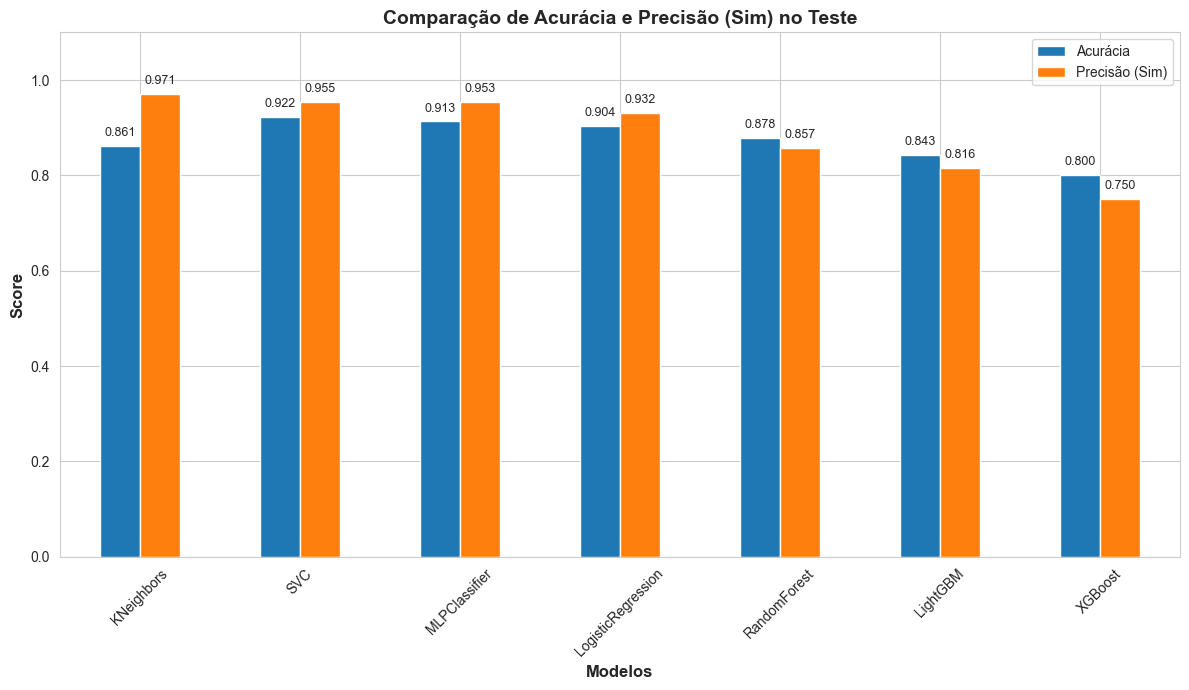


--- Seleção Estatística do Melhor Modelo ---

Etapa 1: Avaliando modelos pela métrica 'Precisão (Sim)'
Candidatos: ['LogisticRegression', 'RandomForest', 'LightGBM', 'XGBoost', 'SVC', 'KNeighbors', 'MLPClassifier']
  Teste de Friedman para 'Precisão (Sim)': p-valor=0.0000
  Matriz de p-valores (Teste de Nemenyi):


,LogisticRegression,RandomForest,LightGBM,XGBoost,SVC,KNeighbors,MLPClassifier
LogisticRegression,1.0000,0.9979,0.0419,0.0093,0.6231,0.9996,0.8081
RandomForest,0.9979,1.0000,0.1766,0.0548,0.2714,0.9600,0.9815
LightGBM,0.0419,0.1766,1.0000,0.9993,0.0001,0.0110,0.6692
XGBoost,0.0093,0.0548,0.9993,1.0000,0.0000,0.0019,0.3627
SVC,0.6231,0.2714,0.0001,0.0000,1.0000,0.8644,0.0340
KNeighbors,0.9996,0.9600,0.0110,0.0019,0.8644,1.0000,0.5444
MLPClassifier,0.8081,0.9815,0.6692,0.3627,0.0340,0.5444,1.0000


  Grupo com melhor desempenho estatístico: ['LogisticRegression', 'RandomForest', 'SVC', 'KNeighbors']

Etapa 2: Avaliando modelos pela métrica 'Acurácia'
Candidatos: ['LogisticRegression', 'RandomForest', 'SVC', 'KNeighbors']
  Teste de Friedman para 'Acurácia': p-valor=0.0000
  Matriz de p-valores (Teste de Nemenyi):


,LogisticRegression,RandomForest,SVC,KNeighbors
LogisticRegression,1.0000,0.6510,0.8660,0.0000
RandomForest,0.6510,1.0000,0.9803,0.0000
SVC,0.8660,0.9803,1.0000,0.0000
KNeighbors,0.0000,0.0000,0.0000,1.0000


  Grupo com melhor desempenho estatístico: ['LogisticRegression', 'RandomForest', 'SVC']

Etapa 3: Avaliando modelos pela métrica 'F1-Score (Macro)'
Candidatos: ['LogisticRegression', 'RandomForest', 'SVC']
  Teste de Friedman para 'F1-Score (Macro)': p-valor=0.0396
  Matriz de p-valores (Teste de Nemenyi):


,LogisticRegression,RandomForest,SVC
LogisticRegression,1.0000,0.1249,0.0898
RandomForest,0.1249,1.0000,0.9877
SVC,0.0898,0.9877,1.0000


  Grupo com melhor desempenho estatístico: ['LogisticRegression', 'RandomForest', 'SVC']

Desempate final: 3 modelos são estatisticamente equivalentes. Selecionando o de maior acurácia no teste.

O VENCEDOR FINAL É: SVC

--- Avaliação Detalhada do Modelo Vencedor: SVC ---
Relatório de Classificação (no conjunto de teste):
              precision    recall  f1-score   support

         Não       0.90      0.97      0.93        66
         Sim       0.95      0.86      0.90        49

    accuracy                           0.92       115
   macro avg       0.93      0.91      0.92       115
weighted avg       0.92      0.92      0.92       115



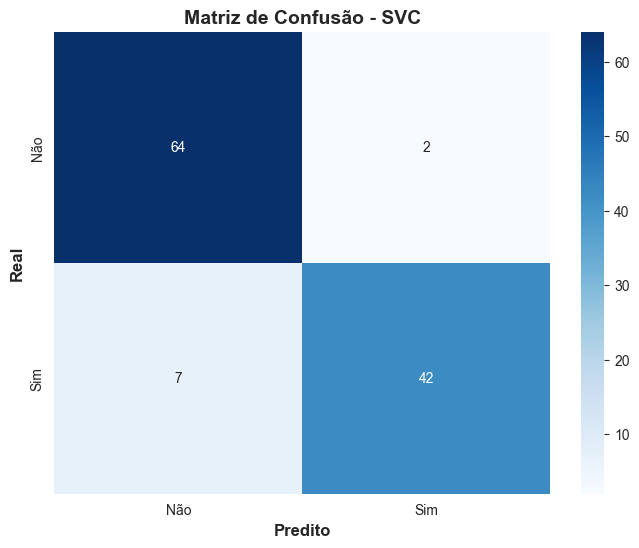


Análise de Feature Importance não é diretamente suportada para o modelo SVC com os parâmetros escolhidos.

--- Gerando relatório final com predições para a base completa ---

Arquivo Excel com todas as predições foi salvo como: 'base_completa_predicoes_final.xlsx'

Análise completa finalizada com sucesso.


In [ ]:

def main():
    FILE_PATH = 'termos_encontrados_rotulados.xlsx'
    df_complete, df_labeled = load_and_prepare_data(FILE_PATH)
    
    plt.figure(figsize=(8, 6))
    class_counts = df_labeled['label'].value_counts()
    plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
    plt.title('Distribuição das Classes Rotuladas', fontsize=14)
    plt.show()

    optimized_models, test_results, cv_results, X_train_text, y_train, X_test_text, y_test, encoder = train_and_optimize_models(df_labeled)
    display_summary_table(test_results, cv_results)
    plot_model_comparison(test_results)
    

    best_model_name = select_best_model_statistically(cv_results, test_results)
    evaluate_final_model(best_model_name, optimized_models, test_results, y_test, encoder)
    generate_final_excel(best_model_name, optimized_models, df_complete, encoder)

    print("\nAnálise completa finalizada com sucesso.")

main()